In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

In [3]:
from osp_solutions.circuits import gate_path_qiskit, gate_path_proposed
from osp_solutions.simulator_dm import compute_distance_trace_unitary_mod_phase
from osp_solutions.hamiltonian import make_H_Heisenberg_path

In [4]:
num_qubits = 6
time_evolution = np.pi / 3
num_steps_list = list(range(10,400,70))
print("trotter step list: ", num_steps_list)

trotter step list:  [10, 80, 150, 220, 290, 360]


In [5]:
H_Heisenberg = make_H_Heisenberg_path(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
H = qi.SparsePauliOp.from_list(list(H_Heisenberg.items()))
print(H)
dm_H = H.to_matrix() ### same, np.allclose(dm_H, matrix_Heisenberg)
U = sp.linalg.expm(-1j * dm_H * time_evolution) ###! same, np.allclose(U, U_Heisenberg)

SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'IXXIII', 'IYYIII', 'IZZIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIIXX', 'IIIIYY', 'IIIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [ ]:
dt = Parameter('dt')

fidelities_conventional_qiskit = []
fidelities_conventional_3cnot = []
fidelities_proposed = []

distances_trace_conventional_qiskit = []
distances_trace_conventional_3cnot = []
distances_trace_proposed = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    matrix_path_qiskit_qiskit = \
        qi.Operator(gate_path_qiskit(num_qubits=num_qubits,
                                        num_steps=num_steps,
                                        dt=time_evolution / num_steps,
                                        to_instruction=True,
                                        add_barrier=False,
                                       )
                   )# .data

    matrix_path_qiskit_3cnot = \
        qi.Operator(gate_path_qiskit(num_qubits=num_qubits,
                                        num_steps=num_steps,
                                        dt=time_evolution / num_steps,
                                        to_instruction=True,
                                        add_barrier=False,
                                       )
                   )# .data

    matrix_kagome_ring_proposed = \
        qi.Operator(gate_path_proposed(num_qubits=num_qubits,
                                        num_steps=num_steps,
                                        dt=time_evolution / num_steps,
                                        to_instruction=True,
                                        add_barrier=False,
                                       )
                   )# .data


    # operator_Hiesenberg = qi.Operator(U_Heisenberg.data)

    fidelities_conventional_qiskit.append(qi.process_fidelity(matrix_path_qiskit_qiskit, qi.Operator(U)))
    fidelities_conventional_3cnot.append(qi.process_fidelity(matrix_path_qiskit_3cnot, qi.Operator(U)))
    fidelities_proposed.append(qi.process_fidelity(matrix_kagome_ring_proposed, qi.Operator(U)))

    distances_trace_conventional_qiskit.append(compute_distance_trace_unitary_mod_phase(matrix_path_qiskit_qiskit.data, qi.Operator(U).data))
    distances_trace_conventional_3cnot.append(compute_distance_trace_unitary_mod_phase(matrix_path_qiskit_3cnot.data, qi.Operator(U).data))
    distances_trace_proposed.append(compute_distance_trace_unitary_mod_phase(matrix_kagome_ring_proposed.data, qi.Operator(U).data))
    
    t2 = time.perf_counter()
    print('process fidelity between conventional_qiskit and U_Heisenberg = {:.4f}'.format(fidelities_conventional_qiskit[-1]))
    print('process fidelity between conventional and U_Heisenberg = {:.4f}'.format(fidelities_conventional_3cnot[-1]))
    print('process fidelity between proposed and U_Heisenberg = {:.4f}'.format(fidelities_proposed[-1]))
    print()
    print('trace norm between conventional_qiskit and U_Heisenberg = {:.4f}'.format(distances_trace_conventional_qiskit[-1]))
    print('trace norm between conventional and U_Heisenberg = {:.4f}'.format(distances_trace_conventional_3cnot[-1]))
    print('trace norm between proposed and U_Heisenberg = {:.4f}'.format(distances_trace_proposed[-1]))
    print("time:", t2 - t1)
    print()

trotter steps:  10


TypeError: gate_path_qiskit() got an unexpected keyword argument 'type_block'

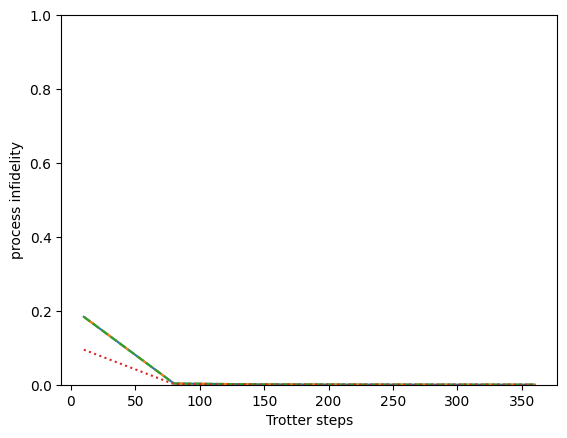

In [ ]:
plt.plot(num_steps_list, 1 - np.array(fidelities_conventional_qiskit))
plt.plot(num_steps_list, 1 - np.array(fidelities_conventional_3cnot), linestyle="dashed")
plt.plot(num_steps_list, 1 - np.array(fidelities_proposed), linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("process infidelity")
# plt.yscale("log")
plt.ylim(bottom=0,top=1)
plt.show()

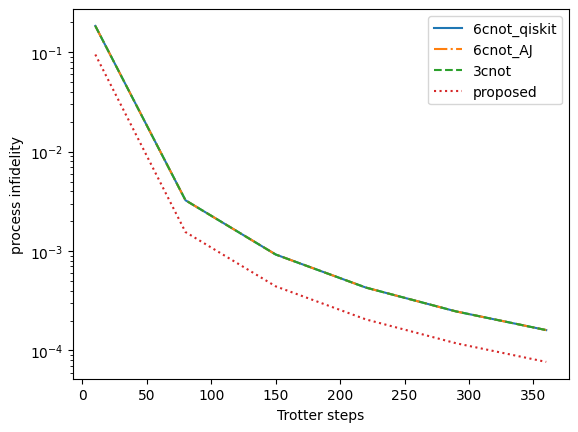

In [ ]:
plt.clf()
p1, = plt.plot(num_steps_list, 1 - np.array(fidelities_conventional_qiskit))
p3, = plt.plot(num_steps_list, 1 - np.array(fidelities_conventional_3cnot), linestyle="dashed")
p4, = plt.plot(num_steps_list, 1 - np.array(fidelities_proposed), linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("process infidelity")
plt.yscale("log")
plt.legend([p1,p3,p4],["6cnot_qiskit","6cnot_AJ","3cnot","proposed"])
plt.show()

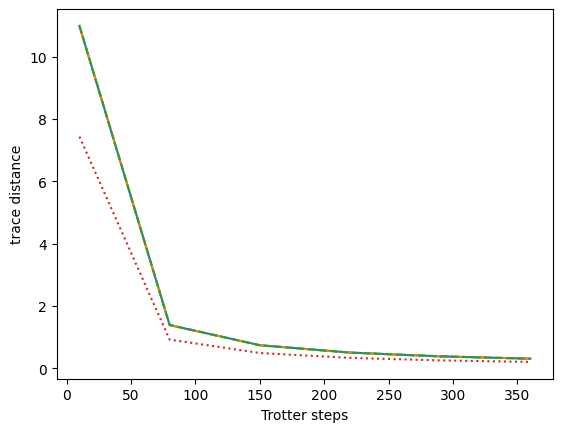

In [ ]:
plt.plot(num_steps_list, distances_trace_conventional_qiskit)
plt.plot(num_steps_list, distances_trace_conventional_3cnot, linestyle="dashed")
plt.plot(num_steps_list, distances_trace_proposed, linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("trace distance")
plt.show()

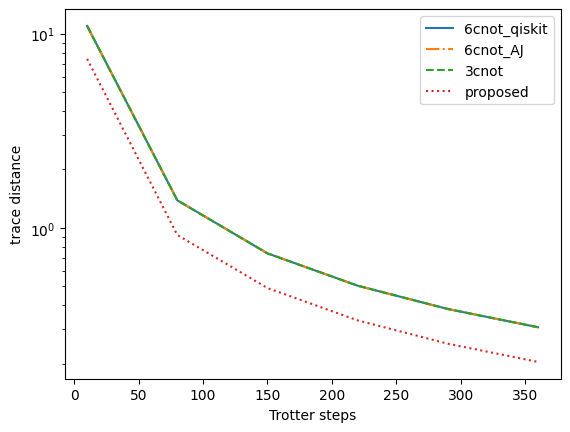

In [ ]:
p1, = plt.plot(num_steps_list, distances_trace_conventional_qiskit)
p3, = plt.plot(num_steps_list, distances_trace_conventional_3cnot, linestyle="dashed")
p4, = plt.plot(num_steps_list, distances_trace_proposed, linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("trace distance")
plt.yscale("log")
plt.legend([p1,p3,p4],["6cnot_qiskit","6cnot_AJ","3cnot","proposed"])
plt.show()

In [ ]:
from qiskit.quantum_info import Operator
from osp_solutions.circuits import gate_block_trotter_qiskit

dt = 0.123
U_block = Operator(gate_block_trotter_qiskit(dt))
H_2 = qi.SparsePauliOp.from_list([("XX",1),("YY",1),("ZZ",1)]).to_matrix()
U_ideal = sp.linalg.expm(-1j * H_2 * dt)

# global phase無視して比較
print(compute_distance_trace_unitary_mod_phase(U_block.data, U_ideal))
evals, evecs = np.linalg.eig(U_block.data.conj().T @ U_ideal)
phase = np.angle(evals[0])
print(np.allclose(U_block.data * np.exp(-1j*phase), U_ideal, atol=1e-8))

1.1651685210552926e-16
True


In [ ]:
from qiskit.quantum_info import Operator
from osp_solutions.circuits import gate_block_trotter_3cnot, gate_block_trotter_6cnot

dt = 0.123
U_block = Operator(gate_block_trotter_6cnot(dt))
H_2 = qi.SparsePauliOp.from_list([("XX",1),("YY",1),("ZZ",1)]).to_matrix()
U_ideal = sp.linalg.expm(-1j * H_2 * dt)

# global phase無視して比較
print(compute_distance_trace_unitary_mod_phase(U_block.data, U_ideal))
evals, evecs = np.linalg.eig(U_block.data.conj().T @ U_ideal)
phase = np.angle(evals[0])
print(np.allclose(U_block.data * np.exp(-1j*phase), U_ideal, atol=1e-8))

4.877758846842238e-16
True


In [ ]:
from qiskit.quantum_info import Operator
from osp_solutions.circuits import gate_block_trotter_3cnot

dt = 0.123
U_block = Operator(gate_block_trotter_3cnot(dt))
H_2 = qi.SparsePauliOp.from_list([("XX",1),("YY",1),("ZZ",1)]).to_matrix()
U_ideal = sp.linalg.expm(-1j * H_2 * dt)

# global phase無視して比較
print(compute_distance_trace_unitary_mod_phase(U_block.data, U_ideal))
evals, evecs = np.linalg.eig(U_block.data.conj().T @ U_ideal)
phase = np.angle(evals[0])
print(np.allclose(U_block.data * np.exp(-1j*phase), U_ideal, atol=1e-8))

5.030096144671609e-16
False
